# <h1 style="text-align: center;"> MHW computing notebook </h1>

This Python notebook computes MHW metrics (per events/per year), and saves them as netCDF files.

## Setup

In [9]:
# Enables modules autoreload (important during development)
%load_ext autoreload
%autoreload 2

# Basic imports
import os

# Define basic paths that may be useful
root_path = os.path.join(os.path.abspath(os.getcwd()), '..')
print(root_path)

/LOCALDATA/ARTHURs_FILES/Codigos/..


In [10]:
# Basic options
clim_period = (1987, 2021)
detrended = False

## Compute REP MHWs

In [14]:
from pyscripts.load_save_dataset import load_rep

# Load the REP dataset
ds_rep = load_rep(region_selector="balears")
ds_rep

Loaded REP dataset.


<xarray.Dataset> Size: 508MB
Dimensions:  (time: 15340, lat: 69, lon: 120)
Coordinates:
  * lat      (lat) float32 276B 37.65 37.7 37.75 37.8 ... 40.96 41.01 41.06
  * lon      (lon) float32 480B -0.8591 -0.8091 -0.7591 ... 4.996 5.046 5.096
  * time     (time) datetime64[ns] 123kB 1982-01-01 1982-01-02 ... 2023-12-31
Data variables:
    T        (time, lat, lon) float32 508MB dask.array<chunksize=(31, 69, 120), meta=np.ndarray>
Attributes:
    institution:               GOS (Global Ocean Satellite monitoring and mar...
    comment:                   WARNING: some applications are unable to prope...
    history:                   GOS-CMEMS processor V4: new version
    Conventions:               CF-1.4 
    title:                     Mediterranean Sea SST Analysis L4, Reprocessed...
    source:                    [1982-present] ESA CCI SST v.3.0 L3C product (...
    references:                A. Pisano, B. Buongiorno Nardelli, C. Tronconi...
    copernicusmarine_version:  2.2.2

In [12]:
ds_rep_old = ds_rep

In [13]:
ds_rep_old

<xarray.Dataset> Size: 508MB
Dimensions:  (time: 15340, lat: 69, lon: 120)
Coordinates:
  * lat      (lat) float32 276B 37.65 37.7 37.75 37.8 ... 40.96 41.01 41.06
  * lon      (lon) float32 480B -0.8591 -0.8091 -0.7591 ... 4.996 5.046 5.096
  * time     (time) datetime64[ns] 123kB 1982-01-01 1982-01-02 ... 2023-12-31
Data variables:
    T        (time, lat, lon) float32 508MB dask.array<chunksize=(1, 69, 120), meta=np.ndarray>
Attributes: (12/51)
    Conventions:                CF-1.4 
    title:                      Mediterranean Sea SST Analysis L4, Reprocesse...
    summary:                    [1982-2018] Daily gap-free maps (L4) at 0.05d...
    references:                 A. Pisano, B. Buongiorno Nardelli, C. Troncon...
    institution:                GOS
    history:                    Mon Jun 10 12:26:11 2024: ncrcat 198201010000...
    ...                         ...
    publisher_name:             CNR ISMAR GOS - CMEMS SST-TAC
    publisher_url:              http://marine.copernicus.eu/
    publisher_email:            servicedesk.cmems@mercator-ocean.eu, gsdk@isa...
    processing_level:           L4
    cdm_data_type:              grid
    NCO:                        netCDF Operators version 5.0.6 (Homepage = ht...

In [19]:
ds_rep.equals(ds_rep_old)

False

In [24]:
import numpy as np
# 1. Compare dimensions
print("Dimensions equal?", ds_rep.dims == ds_rep_old.dims)

for coord in ds_rep.coords:
    a = ds_rep[coord].values
    b = ds_rep_old[coord].values

    if not np.array_equal(a, b):
        print(f"❌ Coordinate '{coord}' differs")
    else:
        print(f"✅ Coordinate '{coord}' matches")



Dimensions equal? True
✅ Coordinate 'lat' matches
✅ Coordinate 'lon' matches
✅ Coordinate 'time' matches


/tmp/ipykernel_14737/2507585214.py:3: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  print("Dimensions equal?", ds_rep.dims == ds_rep_old.dims)


In [23]:
# 3. Compare data variable 'T' directly
are_equal = np.allclose(
    ds_rep["T"].values,
    ds_rep_old["T"].values,
    equal_nan=True
)
print("Data variable 'T' equal?", are_equal)


Data variable 'T' equal? False


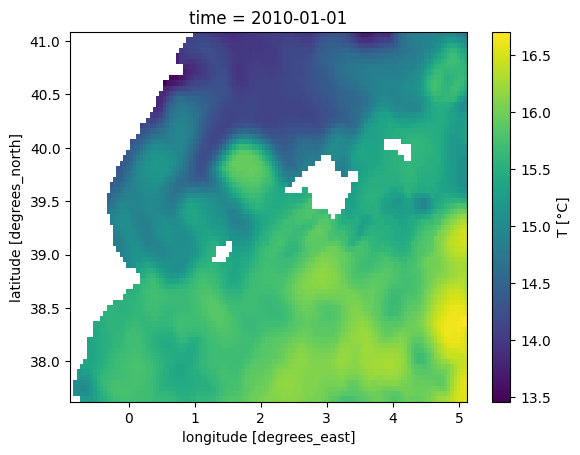

In [26]:
ds_rep.T.sel(time="2010-01-01").plot()

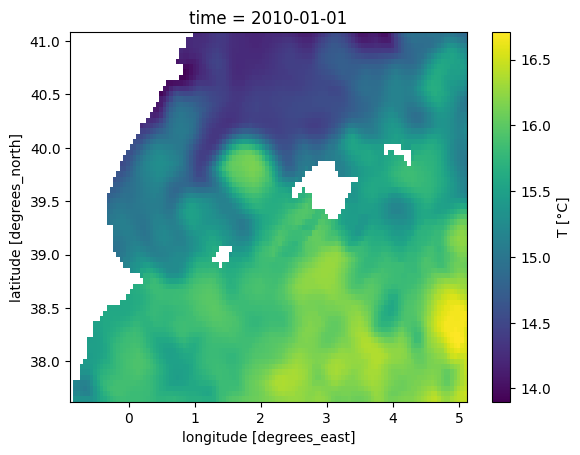

In [28]:
ds_rep_old.T.sel(time="2010-01-01").plot()

In [30]:
import numpy as np
import xarray as xr

# Extract data
T1 = ds_rep["T"]
T2 = ds_rep_old["T"]

# Difference
diff = ds_rep["T"] - ds_rep_old["T"]

# Bias
bias = diff.mean(skipna=True).compute().item()

# RMSD
rmsd = np.sqrt((diff ** 2).mean(skipna=True)).compute().item()

print(f"✅ Bias: {bias:.6f}")
print(f"✅ RMSD: {rmsd:.6f}")


✅ Bias: 0.128617
✅ RMSD: 0.380398


In [ ]:
print(f"✅ RMSD: {rmsd:.2f} °C")
print(f"✅ Bias: {bias:.2f} °C")

✅ RMSD: 0.38 °C
✅ Bias: 0.13 °C


In [25]:
import numpy as np
import xarray as xr

# Load values (triggers compute if dask)
T1 = ds_rep["T"].values
T2 = ds_rep_old["T"].values

# Mask of where values differ (ignoring NaNs)
mask_diff = ~np.isclose(T1, T2, equal_nan=True)

# Check how many values differ
print("Total differing values:", np.sum(mask_diff))

# Get the first few differing indices
diff_indices = np.argwhere(mask_diff)

# Print first 10 locations where values differ
print("First 10 differences at (time, lat, lon):")
for idx in diff_indices[:10]:
    t, lat, lon = idx


KeyboardInterrupt: 

### Whole region

Compute annual metrics for every grip point of REP.

In [ ]:
from pyscripts.mhw_computer import compute_mhw_yearly
from pyscripts.load_save_dataset import save_mhws_dataset

# Lazy compute annual metrics
ds_mhws = compute_mhw_yearly(
    ds_rep,
    using_dataset = "rep",
    clim_period = clim_period,
    detrend = detrended
)

# Perform the computation while saving the annual metrics dataset to .nc file
ds_mhws = save_mhws_dataset(
    ds_mhws,
    ds_type = "yearly",
    dataset_used = "rep",
    region = "balears",
    clim_period = clim_period,
    
    progress_bar = True
)

ds_mhws

In [ ]:
print("Hey blah blah".replace(' ', ' \\ '))

Hey \ blah \ blah


### Spatially averaged REP MHWs

Compute event-wise metrics for region-averaged REP SST.

In [36]:
from pyscripts.mhw_computer import compute_mhw_all_events
from pyscripts.load_save_dataset import save_mhws_dataset

# Average the REP over the whole region
ds_rep_mean = ds_rep.mean(dim=['lon', 'lat'])

# Compute event-wise metrics
ds_mhws = compute_mhw_all_events(
    ds_rep_mean,
    clim_period = clim_period,
    using_dataset = 'rep',
    detrend = detrended
)

# Save the event-wise metrics dataset to .nc file
ds_mhws = save_mhws_dataset(
    ds_mhws,
    ds_type = "all_events",
    dataset_used = "rep_mean",
    detrended = detrended,
    region = "balears",
    clim_period = clim_period,
    
    progress_bar = True
)

ds_mhws

Computing MHWs dataset
[########################################] | 100% Completed | 3.55 sms
Saving MHWs dataset to /LOCALDATA/ARTHURs_FILES/Codigos/../Datos/mhws/all_events/rep_mean_mhws_balears_1987_2021.nc
Created dir /LOCALDATA/ARTHURs_FILES/Codigos/../Datos/mhws/all_events.
 -> Saved!


## Compute MEDREA MHWs

In [ ]:
from pyscripts.load_save_dataset import load_medrea

# Load the MEDREA dataset
ds_medrea = load_medrea(
    region_selector = "balears",
    depth_selector = [0, 50, 100, 150, 200, 500, 700, 1000, 1500, 2000],
)
ds_medrea

Loaded MEDREA dataset.


<xarray.Dataset> Size: 7GB
Dimensions:  (time: 13118, lat: 80, lon: 144, depth: 10)
Coordinates:
  * depth    (depth) float32 40B 1.018 51.38 97.93 ... 1.487e+03 2.001e+03
  * lat      (lat) float32 320B 37.69 37.73 37.77 37.81 ... 40.9 40.94 40.98
  * lon      (lon) float32 576B -0.875 -0.8333 -0.7917 -0.75 ... 5.0 5.042 5.083
  * time     (time) datetime64[ns] 105kB 1987-01-01 1987-01-02 ... 2022-12-31
Data variables:
    bottomT  (time, lat, lon) float32 604MB dask.array<chunksize=(31, 80, 144), meta=np.ndarray>
    T        (time, depth, lat, lon) float32 6GB dask.array<chunksize=(18, 10, 80, 144), meta=np.ndarray>
Attributes:
    title:          Potential Temperature (3D) - Daily Mean
    field_type:     daily_mean_centered_at_time_field
    source:         MFS E3R1
    institution:    Centro Euro-Mediterraneo sui Cambiamenti Climatici - CMCC...
    contact:        servicedesk.cmems@mercator-ocean.eu
    references:     Please check in CMEMS catalogue the INFO section for prod...
    comment:        Please check in CMEMS catalogue the INFO section for prod...
    Conventions:    CF-1.0
    bulletin_date:  20200901
    bulletin_type:  reanalysis
    history:        Tue Apr  8 14:50:31 2025: ncrcat TEMP_MEDSEA_MULTIYEAR_PH...
    NCO:            netCDF Operators version 5.0.6 (Homepage = http://nco.sf....

### Whole region

Compute annual metrics for every grip point of MEDREA.

In [ ]:
from pyscripts.mhw_computer import compute_mhw_yearly
from pyscripts.load_save_dataset import save_mhws_dataset

# Lazy compute annual metrics
ds_mhws = compute_mhw_yearly(
    ds_medrea,
    using_dataset = "medrea",
    clim_period = clim_period,
    detrend = detrended,
)

# Perform the computation while saving the annual metrics dataset to .nc file
save_mhws_dataset(
    ds_mhws,
    ds_type = "yearly",
    dataset_used = "medrea_detrended" if detrended else "medrea",
    clim_period = clim_period,
    region = "balears",

    progress_bar = True
)

ds_mhws

### Spatially averaged MEDREA MHWs

Compute event-wise metrics for region-averaged MEDREA temperature for every depth levels.

In [ ]:
from pyscripts.mhw_computer import compute_mhw_all_events
from pyscripts.load_save_dataset import save_mhws_dataset

# Average the MEDREA over the whole region
ds_medrea_mean = ds_medrea.mean(dim=['lon', 'lat'])

# Compute event-wise metrics
ds_mhws = compute_mhw_all_events(
    ds_medrea_mean,
    clim_period = clim_period,
    using_dataset = 'medrea',
    detrend = detrended
)

# Save the event-wise metrics dataset to .nc file
ds_mhws = save_mhws_dataset(
    ds_mhws,
    ds_type = "all_events",
    dataset_used = "medrea_mean",
    detrended = detrended,
    region = "balears",
    clim_period = clim_period,
    
    progress_bar = True
)

ds_mhws

Computing MHWs dataset
[########################################] | 100% Completed | 471.40 s
Saving MHWs dataset to /LOCALDATA/ARTHURs_FILES/Codigos/../Datos/mhws/all_events/medrea_mean_mhws_balears_1987_2021.nc
 -> Saved!
